In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [43]:
data_path='data/SM-THAI_2905-2608-23.csv'
#trade_sheet='ThaiNov22-Now23'
trade_sheet='SET50_0106-2608-23'
file_name=trade_sheet
file_name='SM-THAI_0106-2608-233'
noFee=False


start_date='2023-05-29'
end_date='2023-08-26'

fee_sheet='Fee'
# data_path=r'D:\PythonDev\MyQuantFinProject\Data\thai_fund.csv'
trade_plan_path='data/Config-BuySellTrade.xlsx'

# excludeFund=['ASP-T12','KKP-TQG']
excludeFund=[]

TotalBudget=100*2000



if noFee==True:
 report_path=f'report/{file_name}(no-fee).xlsx'
else:
 report_path=f'report/{file_name}.xlsx' 
print(report_path)
# trade_sheet='BuySell_Buy_Hold'
# report_path=f'report/BuySell_4ETFFunds.xlsx'


report/SM-THAI_0106-2608-233.csv.xlsx


# Read Price CSV

In [44]:
df=pd.read_csv(data_path,parse_dates=['Date/Time'],dayfirst=True)
df.columns=['symbol','date','price']
df=df.query('date>=@start_date and date<=@end_date')
df.info()
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427 entries, 0 to 426
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  427 non-null    object        
 1   date    427 non-null    datetime64[ns]
 2   price   427 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.3+ KB
         symbol       date  price
197  KKP-SM-CAP 2023-06-19  14.87
361      KTMSEQ 2023-08-21  18.18
290     KKP-TQG 2023-08-04   8.02
244     KKP-TQG 2023-05-29   8.04
296     KKP-TQG 2023-08-15   8.10
28      ASP-SME 2023-07-07  18.47
406   TISCOMS-A 2023-07-25  19.23
148    KFTHAISM 2023-07-05  12.68
6       ASP-SME 2023-06-07  19.37
331      KTMSEQ 2023-07-05  17.97


# List Symbol and Plot Chart

In [45]:
list_symbols=list(df['symbol'].unique())
list_symbols=[ f for f in list_symbols if f not in excludeFund ]
list_symbols
# list_symbols=['ACWI']


['ASP-SME',
 'K-MIDSMALL',
 'KFTHAISM',
 'KKP-SM-CAP',
 'KKP-TQG',
 'KTMSEQ',
 'TISCOMS-A']

['ASP-SME', 'K-MIDSMALL', 'KFTHAISM', 'KKP-SM-CAP', 'KKP-TQG', 'KTMSEQ', 'TISCOMS-A']
==============================ASP-SME==============================


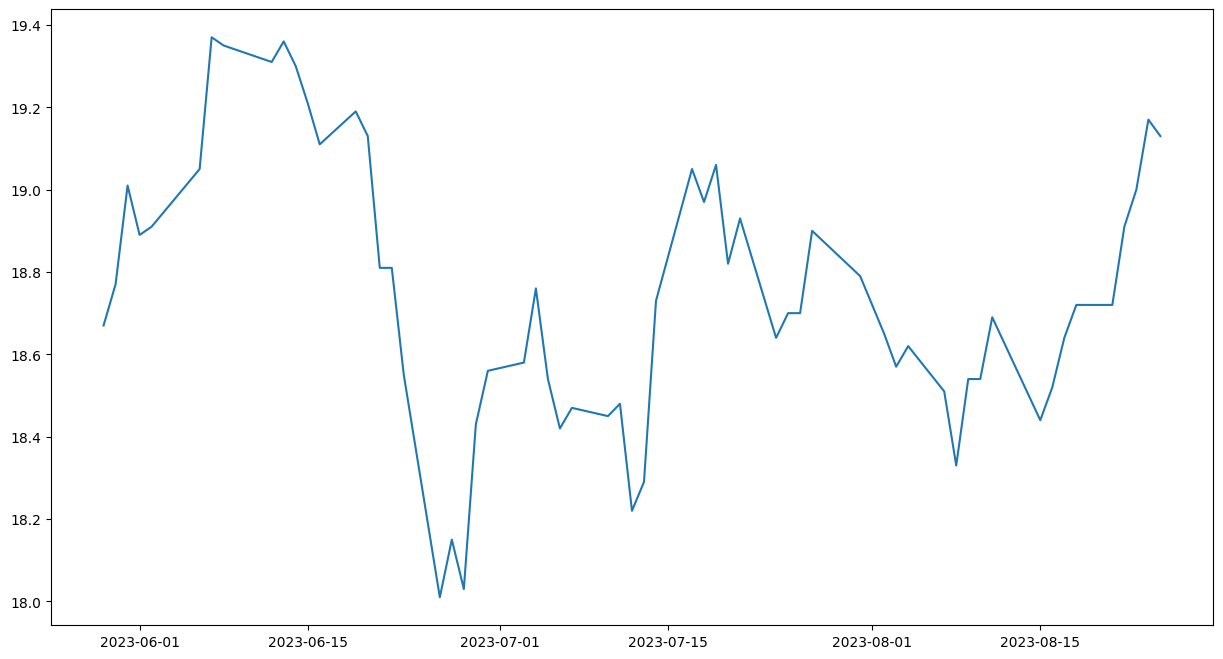

==============================K-MIDSMALL==============================


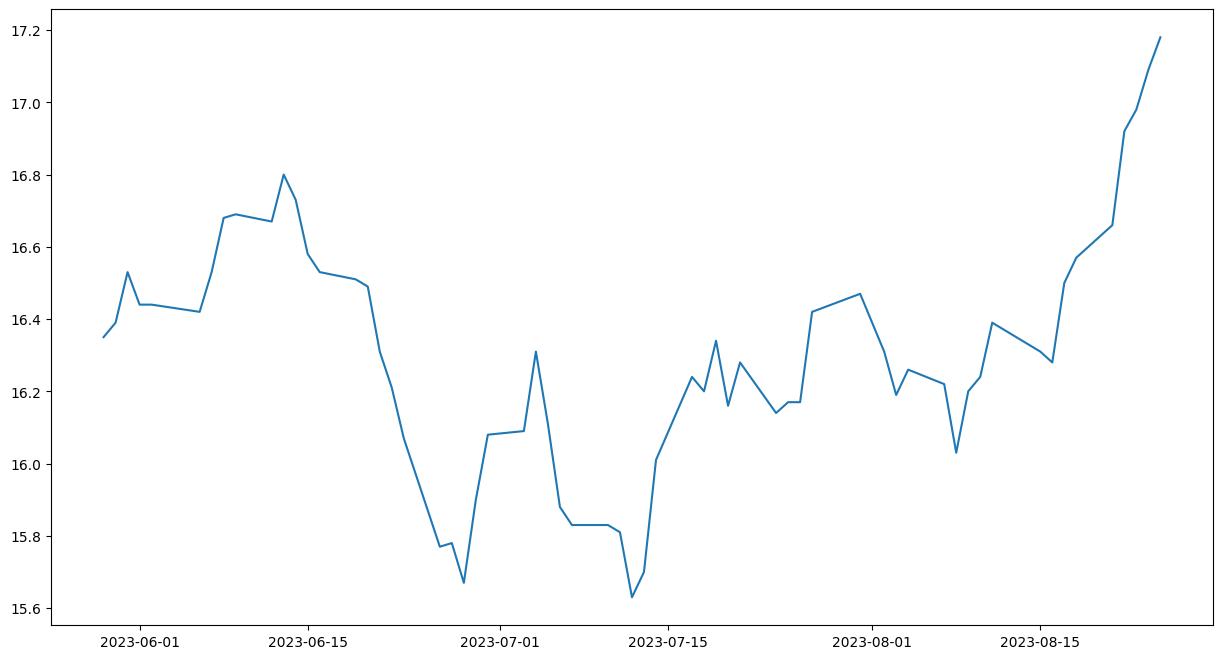

==============================KFTHAISM==============================


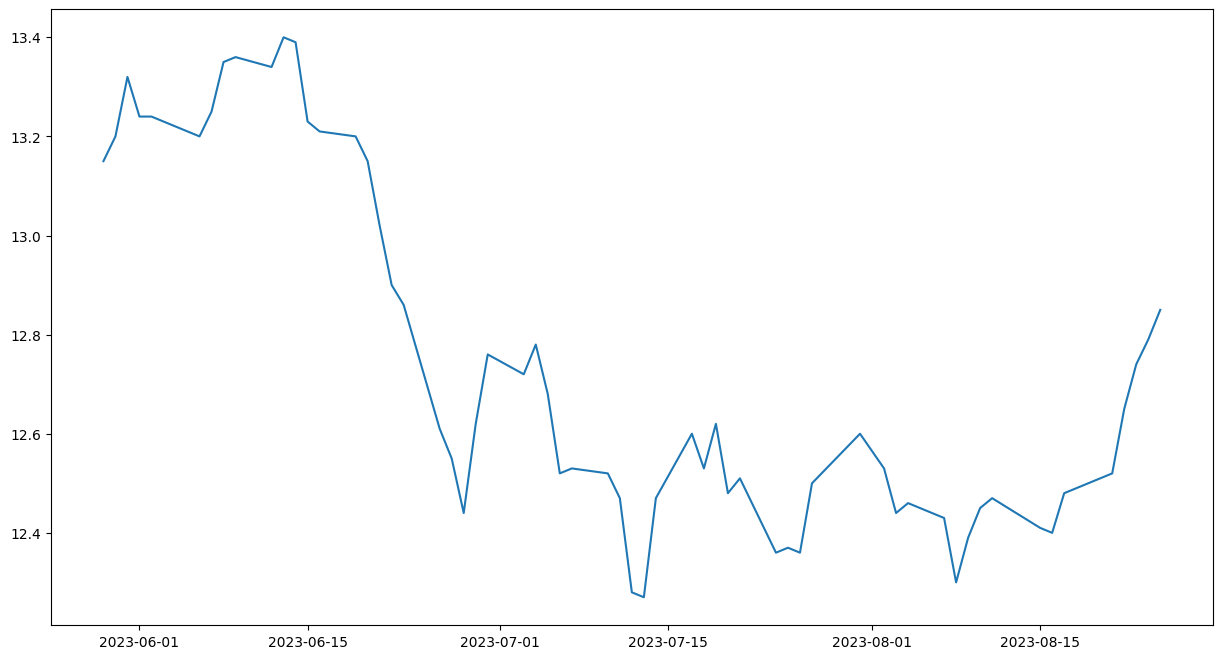

==============================KKP-SM-CAP==============================


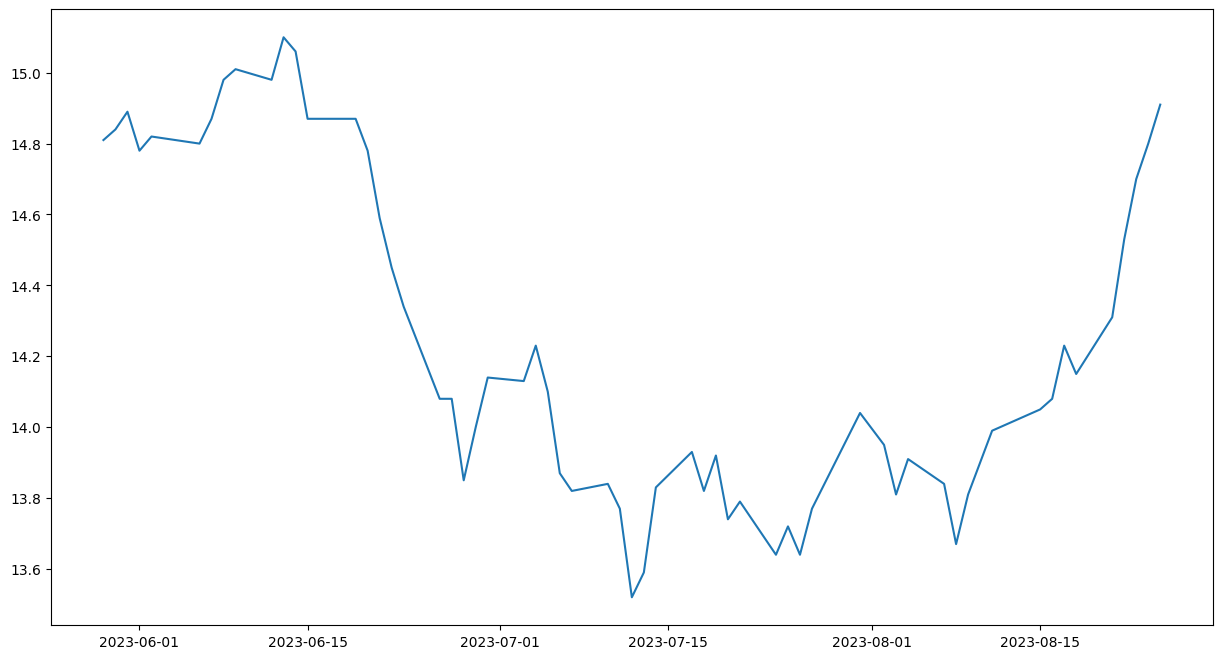

==============================KKP-TQG==============================


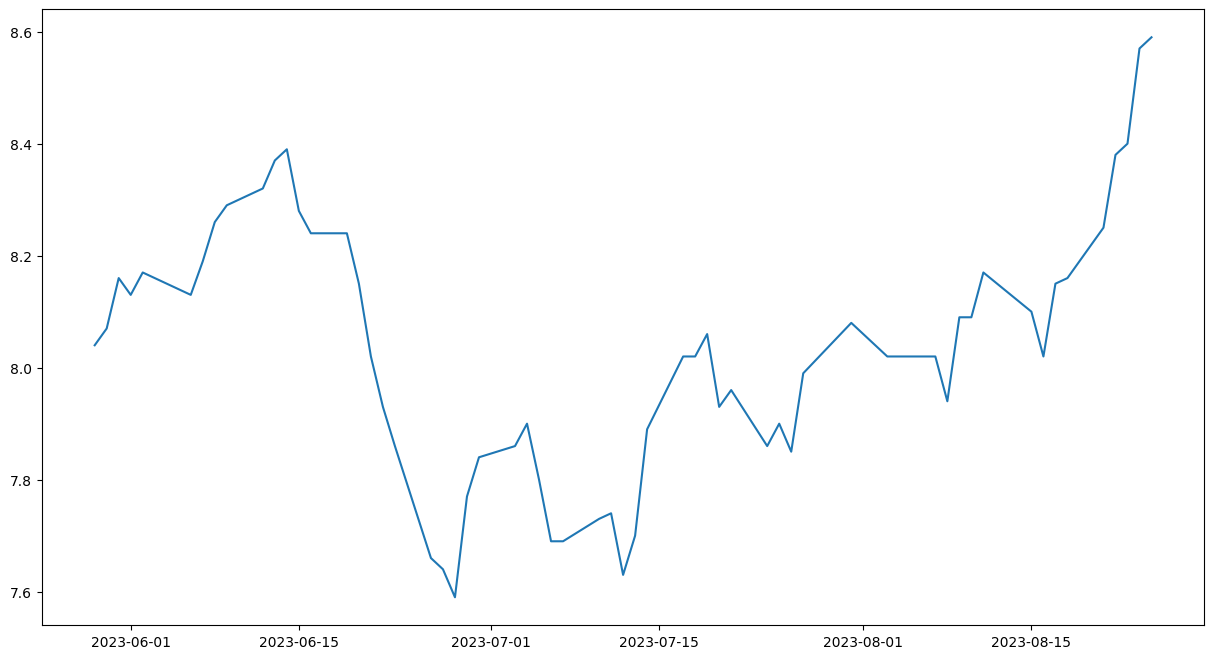

==============================KTMSEQ==============================


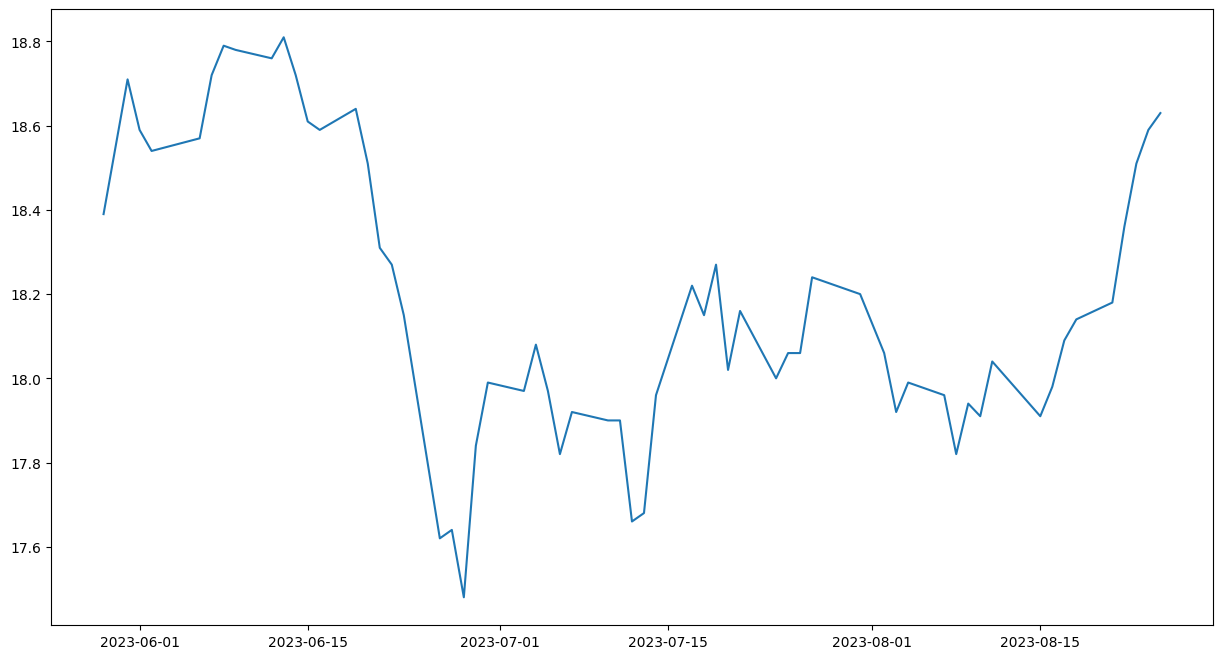

==============================TISCOMS-A==============================


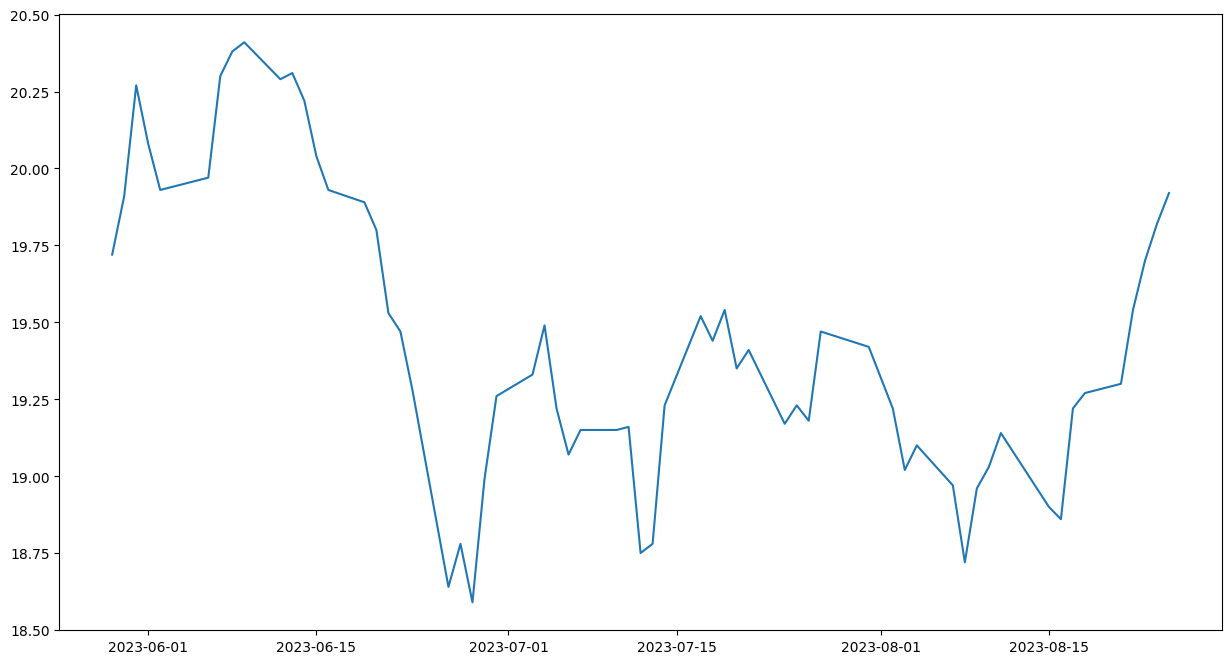

In [46]:
print(list_symbols)
for  symbol in list_symbols:
    print(f"=============================={symbol}==============================")
    dfFund=df.query('symbol==@symbol')
    plt.figure(figsize=(15, 8))
    plt.plot(dfFund['date'],dfFund['price'])
    plt.show()

# Get Trade Data and Fee

In [47]:
# read feeon 
dfAssetInfo=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=fee_sheet,\
                    index_col='symbol', dtype ={'buy_fee_pct': np.float64,'sell_fee_pct': np.float64})

# check where  fund fee  in portfolio  are avaible?
dfNoFeeInfo= [ item for item in list_symbols if item not in list(dfAssetInfo.index)]
dfAssetInfo=dfAssetInfo.loc[list(list_symbols),:]

if noFee==True:
    dfAssetInfo[['buy_fee_pct','sell_fee_pct']]=0
    
print("fee info")
print(dfAssetInfo) 
# For instance   AAXJ Price=100 but we need to pay 101 $

fee info
            buy_fee_pct  sell_fee_pct      region
symbol                                           
ASP-SME            1.25           0.0  thai-small
K-MIDSMALL         1.00           0.0  thai-small
KFTHAISM           1.00           0.0  thai-small
KKP-SM-CAP         1.00           0.0  thai-small
KKP-TQG            0.50           0.0  thai-small
KTMSEQ             1.00           0.0  thai-small
TISCOMS-A          1.00           0.0  thai-small


In [48]:
dfPlan=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=trade_sheet, \
                     parse_dates=['trade_date'],dtype ={'portion_pct': np.float64})

#total buy portion is equal or greater than sell portion
buy_sum_act=dfPlan.query("action=='b'").portion_pct.sum()
sell_sum_act=dfPlan.query("action=='s'").portion_pct.sum()

all_portion=0

In [49]:
if buy_sum_act<sell_sum_act:
  raise Exception("Not allow Buy <= Sell")   
else:
    if buy_sum_act>sell_sum_act:
       print("=============Calculate the last portion to be sellable")
       sellAllAtNow=buy_sum_act-sell_sum_act 
       dfLastPrice=pd.DataFrame(columns=list(dfPlan.columns), data=[ [df['date'].max(),sellAllAtNow,'s']])
       print(dfLastPrice)
       dfPlan=pd.concat([dfPlan,dfLastPrice])
       dfPlan=dfPlan.reset_index(drop=True)

    tradeDateList= [ d for d in list(dfPlan['trade_date']) ]    
    all_portion=buy_sum_act   
    print(f"portion = {all_portion} on")
    
print("==========================Summarize All Trade==========================================")
print(f"No Buy/Sell {dfPlan.groupby(['action']).size()}")
print(dfPlan)

=============Calculate the last portion to be sellable
  trade_date  portion_pct action
0 2023-08-25        100.0      s
portion = 100.0 on
==========================Summarize All Trade==========================================
No Buy/Sell action
b    5
s    1
dtype: int64
  trade_date  portion_pct action
0 2023-06-07         20.0      b
1 2023-06-30         20.0      b
2 2023-07-20         20.0      b
3 2023-08-10         20.0      b
4 2023-08-22         20.0      b
5 2023-08-25        100.0      s


In [50]:
# To make it easier for use to understand portfolio transatoin 
rrr=TotalBudget % all_portion
if rrr !=0 :
  raise Exception(f"Your Budget {TotalBudget} is  not proportional  Portion with {all_portion}")
else:
  print(f"Your Budget {TotalBudget} is  proportional  Portion with {all_portion}")

Your Budget 200000 is  proportional  Portion with 100.0


# Custom Function

In [51]:
# figure out the amount of qty from total fund total value
def get_qty_buy(item):
    xCost=(item['portion_pct']/all_portion)*TotalBudget  
    xPrice=item['price_on_fee']
    qty=xCost/xPrice
    return qty

# figure the amount of  qty out  from total qty
def get_qty_sell(item,TotalQty):  
    qty=(item['portion_pct']/all_portion)*TotalQty
    return qty

In [52]:
def set_fee_by_action(item):
  x=item['symbol']  
  if item['action']=='b':
    fee_type='buy_fee_pct'
  elif  item['action']=='s':
    fee_type='sell_fee_pct'
  try:
     return dfAssetInfo.loc[x,fee_type]
  except Exception as ex:
     print(f"Error : no {x} to get fund fee")
     return 0

In [53]:
dict_dfTran={}
dfSummary=pd.DataFrame(columns=['Symbol','BuyValue','AvgBuyPrice','SellValue','AvgSellPrice','PL','Percent_PL'])

dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL


In [54]:
#https://www.w3resource.com/pandas/dataframe/dataframe-apply.php

for symbol in list_symbols:
    print(f"*******************{symbol}*******************")

    dfBS=df[ (df['symbol']==symbol) & (df['date'].isin(tradeDateList))]
    # if len(tradeDateList)==len(dfBS):
        
     # Step1  join price data (filter by sybom and the date whiich you have buy/sell action)   
    dfBS=dfBS.merge(dfPlan,how='inner',left_on='date',right_on='trade_date')
     # remove  redundant data  
    dfBS=dfBS.drop(columns=['trade_date'])     
       
    
     # Step2 calculate fee function
    dfBS['fee']=dfBS.apply(set_fee_by_action,axis=1) # 2.1
    
     # The price that allows you to buy the fund is more expensive than the actual asset price  1%  ,other the other had 
     # Buy price*1.0x=??   
    dfBS['price_on_fee']=dfBS.apply(lambda item : item['price']*(1+ (item['fee']/100)) if item['action']=='b' else item['price']*(1-(item['fee']/100)), axis=1)
    dfBS['price_on_fee']=dfBS['price_on_fee'].round(2) #2.2   
    # print(dfBS)
        
     # Step3  To make it easier to calculate and trading sumary in tearm of qty both buy/sell , both use different way
     # we recommend spliting this dataframe  into 2 dataframe
     #  BuyDataFrame and Sell Date , and we will merge both later  
    
    #3.1 query only buy action
    print("======================Buy=======================")
    buyDF=dfBS.query("action=='b'")   
    
    # 3.2 send the  row to function to calculate qty 
    buyDF['qty']=buyDF.apply(get_qty_buy,axis=1) 
    buyDF['value']=round(buyDF['qty']*buyDF['price_on_fee'],0)
    
    
    # 1 is buy (I will take columne to apply cumsum function to calcaulate cumulative return
    buyDF['action_value']=buyDF['value']
    buyDF['action_qty']=buyDF['qty']
    
    # 3.3 Total qty and value and avg
    TotalQty=buyDF['qty'].sum()
    TotalValue=round(buyDF['value'].sum(),0)
    AvgPrice=round(TotalValue/TotalQty,2)
    
    # print(buyDF[['date','portion_pct','value' ,'price','fee','price_on_fee','qty']])
    
    
    # Step4 follow every step corresponidng to prev step#3
    print("=======================Sell=======================")
    # step#4.1
    sellDF=dfBS.query("action=='s'")  
    
    # ste#4.2
    sellDF['qty']=sellDF.apply(get_qty_sell,axis=1,args=(TotalQty,))
    sellDF['value']=round(sellDF['qty']*sellDF['price_on_fee'],0)
    
    # -1 is sell (I will take columne to apply cumsum function to calcaulate cumulative return
    sellDF['action_value']=sellDF['value']*-1
    sellDF['action_qty']=sellDF['qty']*-1
    
    # print(sellDF[['date' ,'portion_pct','value','price','fee','price_on_fee','qty']])
    

    
    print("======================Merge Buy & Sell======================")
    # step 5  concatenate buy and sell dataframe 
    dfTran=pd.concat([buyDF,sellDF],axis=0)
    dfTran=dfTran.sort_values(by=['date'])
    dfTran[['value','action_value']]=dfTran[['value','action_value']].round(0)

    # step 6 accumulate value and qury over entire data since start buying to last record 
    dfTran['net_value']=dfTran['action_value'].cumsum(axis = 0) 
    dfTran['net_qty']=dfTran['action_qty'].cumsum(axis = 0)  
    dfTran['avg_price']=round( dfTran['net_value']/dfTran['net_qty'],2)
    
    dfTran=dfTran.sort_values(by=['date'])
    # print(dfTran[['date' ,'action','price_on_fee','qty','net_qty','value','net_value','avg_price']])
    print(dfTran[['date' ,'action','price_on_fee','qty','value','avg_price']])
    
    dict_dfTran[symbol]=dfTran
    
    print("=======================Summarize Gain/Loss=======================")
    #step 7 create total buy/sell value , avg prie and profit/loss(value and %) of  all funds 
    # step 7.1 apply sum agg over  value and qty to find avg throughout  the whold dataframe
    SellTotalQty=sellDF['qty'].sum()
    SellTotalValue=round(sellDF['value'].sum(),0)
    SellAvgPrice=round(SellTotalValue/SellTotalQty,0)
    
    print(f"Total Buy {symbol} : qty={TotalQty} and value={TotalValue} at AvgPrice={AvgPrice}")
    print(f"Total Sell {symbol} : qty={SellTotalQty} and value={SellTotalValue} at AvgPrice={SellAvgPrice}")
    

    
    # step #7.2
    PL=round(SellTotalValue-TotalValue,0)
    PCT_PL=round(PL/TotalValue*100,2)
    
    # step# 7.3 
    # you take amont 100000.0 and gain profit103500 from investment on this etf fund 
    summary_data={'Symbol':symbol,'BuyValue':TotalValue,'AvgBuyPrice':AvgPrice,'SellValue':SellTotalValue,\
                  'AvgSellPrice':SellAvgPrice, 'PL':PL,'Percent_PL':PCT_PL
                 }
    dfSummary=dfSummary.append(summary_data,ignore_index=True)
    
    print(dfSummary)

    


*******************ASP-SME*******************
======================Buy=======================
=======================Sell=======================
======================Merge Buy & Sell======================
        date action  price_on_fee           qty     value  avg_price
0 2023-06-07      b         19.61   2039.775625   40000.0      19.61
1 2023-06-30      b         18.79   2128.791911   40000.0      19.19
2 2023-07-20      b         19.06   2098.635887   40000.0      19.15
3 2023-08-10      b         18.77   2131.060202   40000.0      19.05
4 2023-08-22      b         19.15   2088.772846   40000.0      19.07
5 2023-08-25      s         19.13  10487.036470  200617.0       -inf
=======================Summarize Gain/Loss=======================
Total Buy ASP-SME : qty=10487.036470349409 and value=200000.0 at AvgPrice=19.07
Total Sell ASP-SME : qty=10487.036470349409 and value=200617.0 at AvgPrice=19.0
    Symbol  BuyValue  AvgBuyPrice  SellValue  AvgSellPrice     PL  Percent_PL
0  ASP

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6748\186035005.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['qty']=buyDF.apply(get_qty_buy,axis=1)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6748\186035005.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['value']=round(buyDF['qty']*buyDF['price_on_fee'],0)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6748\186035005.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [55]:
dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL
0,ASP-SME,200000.0,19.07,200617.0,19.0,617.0,0.31
1,K-MIDSMALL,200000.0,16.54,207686.0,17.0,7686.0,3.84
2,KFTHAISM,200000.0,12.84,200195.0,13.0,195.0,0.10
3,KKP-SM-CAP,200000.0,14.37,207545.0,15.0,7545.0,3.77
4,KKP-TQG,200000.0,8.12,211536.0,9.0,11536.0,5.77
5,KTMSEQ,200000.0,18.38,202754.0,19.0,2754.0,1.38
6,TISCOMS-A,200000.0,19.68,202434.0,20.0,2434.0,1.22


In [56]:
dfPort=dfSummary[['BuyValue','SellValue','PL']].sum().to_frame('All Funds')
dfPort=dfPort.T
dfPort['PercentPL']=round( (dfPort['PL']/dfPort['BuyValue'] *100) ,0)
dfPort

,BuyValue,SellValue,PL,PercentPL
All Funds,1400000.0,1432767.0,32767.0,2.0


In [57]:
writer=pd.ExcelWriter(report_path,engine='xlsxwriter') 

dfPort.to_excel(writer,sheet_name='TotalPort',index=False)

dfSummary=dfSummary.sort_values(by=['Percent_PL'],ascending=False)
dfSummary.to_excel(writer, sheet_name="Summary",index=False)

for symbol,tranDF in dict_dfTran.items():
 tranDF=tranDF.drop(columns=['symbol'])   
 tranDF.to_excel(writer, sheet_name=symbol,index=False) 
writer.save()

writer.close()

print("Successfully")

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6748\886247830.py:11: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Successfully


C:\Users\pongthsa\AppData\Roaming\Python\Python39\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
